In [65]:
#default_exp basics_v2

# Linear models & causaling - v2
> Playground for causal modelling on various kinds of generated synthetic data and causal graphs.

**References**

References for the dowhy package:
* Documentation: [here](https://microsoft.github.io/dowhy/)
* GitHub: [here](https://github.com/microsoft/dowhy)

Material which helped my introductory reading so far by :
* degeneratestate.org: [Pt I - potential outcomes](http://www.degeneratestate.org/posts/2018/Mar/24/causal-inference-with-python-part-1-potential-outcomes/) (contains definitions of ATE, ATT and ATC, among other things)
* degeneratestate.org: [Pt II - causal graphs & the backdoor criterion](http://www.degeneratestate.org/posts/2018/Jul/10/causal-inference-with-python-part-2-causal-graphical-models/)
* this youtube video [on backdoor paths](https://www.youtube.com/watch?v=F8vcki-uWJc) 
* Rubin et al. 2005 on [causal inference and potential outcomes](http://www.stat.unipg.it/stanghellini/rubinjasa2005.pdf)
* wiki article on the [average treatment effect (ATE)](https://en.wikipedia.org/wiki/Average_treatment_effect)
* this wiki article [on propensity score matching](https://en.wikipedia.org/wiki/Propensity_score_matching) 

**Content in this notebook**
* generate your synthetic data → `obs`
* do some basic analysis of that data using a random forest → `model`
* create your hypothesis (causal graph) about your data using the networkx package → `causal_model`
* compute causal estimand, causal effect and potential refutations using the dowhy package

**Open questions**
* How is matching or grouping done in categorical vs continuous treatment variable cases?
* How to visualize ATT, ATC and ATE and the reasoning for their potential  different applications? 
* Meaning of *regression discontinuity*?
* Meaning of *instrumental variable*?

In [2]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#export
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import networkx as nx
from sklearn import ensemble, metrics
import dowhy as dw

In [4]:
#hide
mpl.style.use('bmh')

## Generating data → `obs`

### Data generating model: $ Y = a \cdot X_1 ^ b + c + X_2 $

In [5]:
n = 1000
a,b,c = 1.5, 1., 0
target = 'Y'
obs = pd.DataFrame(columns=['X0', 'X1', target])
obs['X0'] = stats.uniform.rvs(loc=-1, scale=2, size=n)
obs['X1'] = stats.norm.rvs(loc=0, scale=.1, size=n)
obs[target] = a * obs.X0 ** b + c + obs.X1

In [6]:
obs.head()

,X0,X1,Y
0,0.937283,-0.028384,1.377540
1,0.709670,0.197873,1.262378
2,0.810501,-0.159339,1.056412
3,-0.567703,0.170019,-0.681536
4,0.967475,0.016748,1.467960


### Visualizing `obs`

In [7]:
obs.describe()

,X0,X1,Y
count,1000.000000,1000.000000,1000.000000
mean,-0.012044,-0.002617,-0.020683
std,0.571279,0.099986,0.859728
min,-0.998848,-0.321081,-1.739024
25%,-0.497578,-0.070304,-0.741928
50%,-0.042777,-0.001146,-0.041097
75%,0.468279,0.069962,0.689997
max,0.998981,0.311356,1.620401


Covariation of the target variable with all other variables individually as observed (still being all confounded and what not)

In [8]:
#export
def plot_target_vs_rest(obs:pd.DataFrame, target:str='Y'):
    in_cols = [col for col in obs.columns if target!=col]
    
    for in_col in in_cols:
        fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
        ax.scatter(obs[in_col], obs[target], alpha=.1, marker='o')
        ax.set(xlabel=f'"{in_col}"', ylabel=f'"{target}"', 
               title=f'"{target}" vs "{in_col}"')
        plt.show()

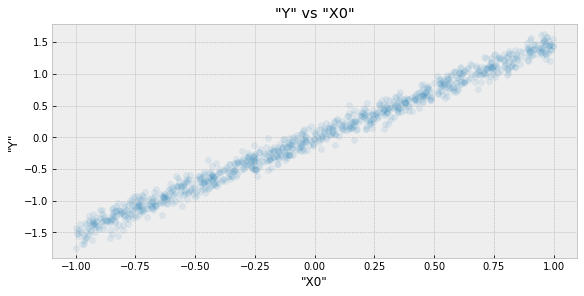

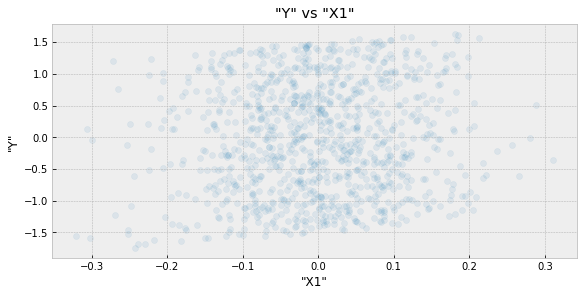

In [9]:
plot_target_vs_rest(obs)

Distribution of each individual variables observed values

In [10]:
#export
def plot_var_hists(obs:pd.DataFrame, bins:int=50):
    for col in obs.columns:
        fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
        ax.hist(col, data=obs, bins=bins, density=True)
        ax.set(title=f'"{col}" distribution', xlabel=f'"{col}"',
               ylabel=f'Frequency')
        plt.show()

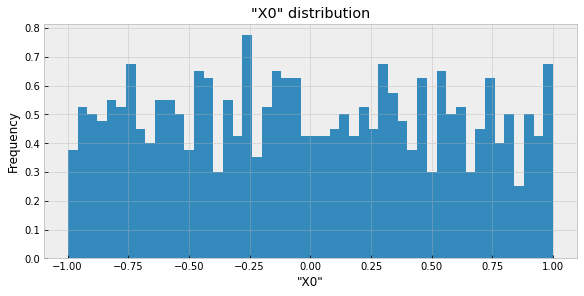

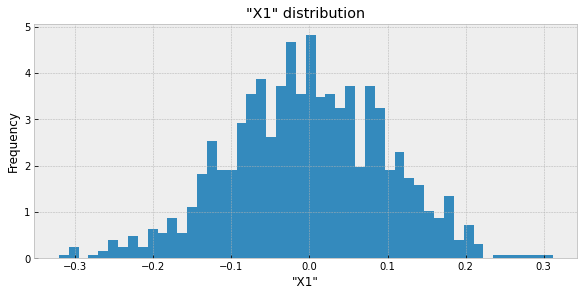

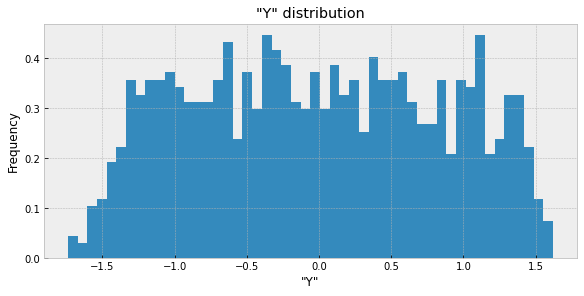

In [11]:
plot_var_hists(obs)

Looking at correlations to get an idea of what interaction might be important

In [12]:
#export
def show_correlations(obs:pd.DataFrame, method:str='spearman'):
    cols = obs.columns
    n = len(cols)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(obs.corr(method=method))
    ax.set(xticks=range(n), xticklabels=cols,
           yticks=range(n), yticklabels=cols)
    plt.show()

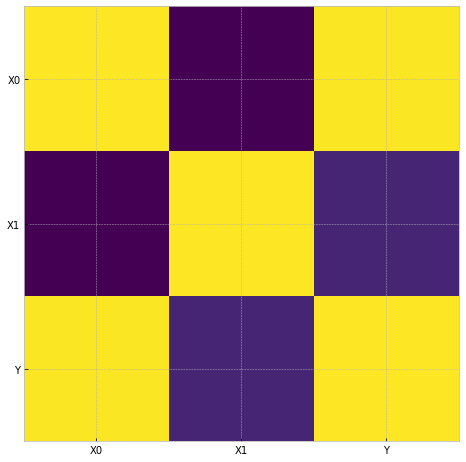

In [13]:
show_correlations(obs)

### Random Forest model: feature importance & partial dependency

In [14]:
#export 
def get_Xy(obs:pd.DataFrame, target:str='Y'):
    not_target = [c for c in obs.columns if c!=target]
    X, y = obs.loc[:, not_target].values, \
           obs.loc[:, target].values.ravel()
    return X, y, not_target

In [15]:
X, y, not_target = get_Xy(obs, target=target)
model = ensemble.RandomForestRegressor(n_estimators=100, max_features='sqrt')
model.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Getting a feeling for the quality of the model

In [16]:
#export
def get_model_feel(model, obs:pd.DataFrame, target:str='Y',
                   bins:int=50):
    X, y, not_target = get_Xy(obs, target=target)
    _y = model.predict(X)
    Δ = _y - y
    
    fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
    ax.hist(Δ, bins=bins, density=True)
    ax.set(xlabel='$\Delta = y_p - y_t$', ylabel='Frequency',
           title='Model prediction residuals')
    plt.show()
    
    for var in not_target:
        fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
        ax.scatter(obs[var], obs[target], alpha=.1, marker='o', label='truth')
        ax.scatter(obs[var], _y, alpha=.1, marker='x', label='prediction')
        ax.set(xlabel=f'"{var}"', ylabel=f'"{target}"',
               title='Model prediction vs truth: "{var}"')
        ax.legend(loc='best')
        plt.show()

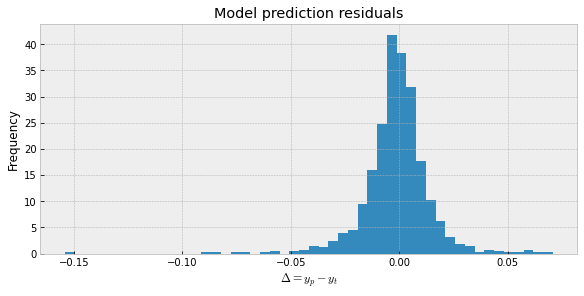

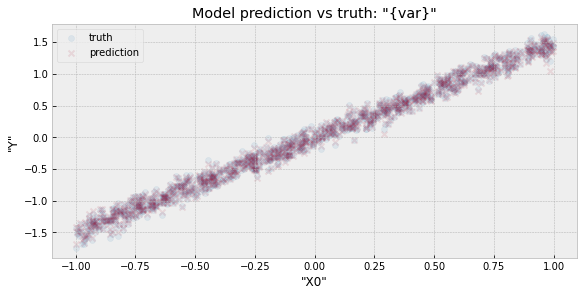

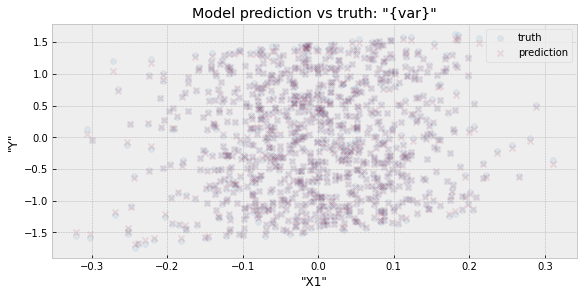

In [17]:
get_model_feel(model, obs, target=target)

Looking at which features are particularly important for the prediction

In [18]:
#export
def get_feature_importance(m, obs:pd.DataFrame, target:str='Y',
                           metric:callable=metrics.mean_squared_error):
    X, y, not_target = get_Xy(obs, target=target)
    n_obs, n_row = X.shape
    scores = {}
    for i in range(n_row):
        _X = X.copy()
        np.random.shuffle(_X[:,i])
        _y = m.predict(_X)
        scores[i] = metric(y, _y)
        
    scores = pd.DataFrame([{'variable': not_target[i], 'feature_importance': scores[i]} for i in scores]) 
    scores.sort_values('feature_importance', ascending=False, inplace=True)
    return scores

In [19]:
fi_scores = get_feature_importance(model, obs,
                                   metric=metrics.mean_squared_error)
fi_scores.head()

,variable,feature_importance
0,X0,1.407511
1,X1,0.018463


Looking at partial dependencies

In [20]:
#export
def get_partial_dependencies(model, obs:pd.DataFrame,
                             target:str='Y', max_num_obs:int=100, 
                             max_num_ys:int=10):
    
    assert max_num_ys > 0
    X, y, not_target = get_Xy(obs, target=target)
    n_obs, n_row = X.shape
    part_deps = {}
    
    for ix, var in enumerate(not_target):
        
        ys = {}
        idp_vals = np.unique(X[:,ix])
        n_u = len(idp_vals)
        
        step = n_u//max_num_ys if max_num_ys >= n_u else 1
        idp_vals = idp_vals[::step]
    
        if max_num_obs:
            if max_num_obs >= n_obs:
                ixs = np.arange(n_obs)
            else:
                ixs = np.random.choice(np.arange(n_obs), size=max_num_obs,
                                       replace=False)
        for i, val in enumerate(idp_vals):
            _X = X[ixs,:].copy()
            _X[:,ix] = val
            _y = model.predict(_X)
            ys[i] = _y.copy()

        part_deps[var] = pd.DataFrame({val: ys[i] for i,val in enumerate(idp_vals)})
    return part_deps

In [21]:
%%time
part_deps = get_partial_dependencies(model, obs, target=target,
                                     max_num_obs=100, 
                                     max_num_ys=10)

CPU times: user 10.3 s, sys: 250 ms, total: 10.6 s
Wall time: 10.6 s


In [49]:
#export
def plot_partial_dependencies(part_deps:pd.DataFrame,
                              target:str='Y'):
    
    for var in part_deps:
        fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
        x = part_deps[var].columns.values
        for i, row in part_deps[var].iterrows():
            obs_line, = ax.plot(x, row.values, alpha=.1, lw=1, color='black', label='single obs.')
        avg = part_deps[var].mean(axis=0)
        avg_line, = ax.plot(x, avg, lw=2, color='yellow', label='avg.')
        ax.set(xlabel=f'"{var}"', ylabel=f'"{target}"', title=f'Partial dependency plot "{target}" vs "{var}"')
        ax.legend(loc='best', handles=[obs_line, avg_line])
        plt.show()

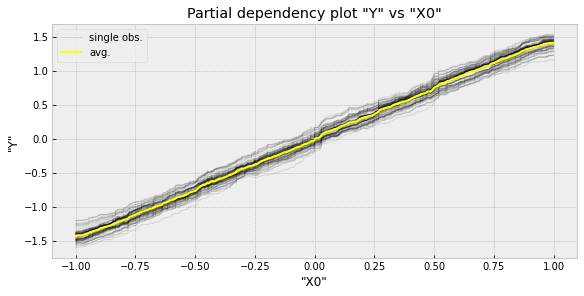

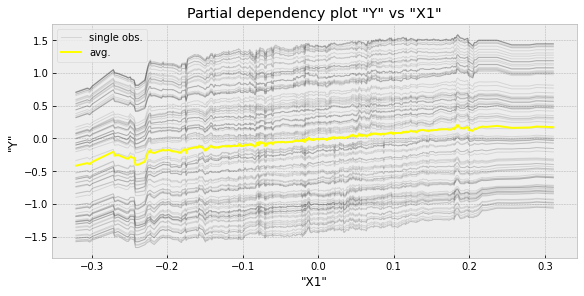

In [50]:
plot_partial_dependencies(part_deps, target='Y')

## Generating a graphical model → `g`

In [24]:
#export
class GraphGenerator:
    'Generates some specific directed graphs for `obs`'
    def __init__(self, obs:pd.DataFrame, target:str='Y'):
        self.not_targets = [col for col in obs.columns if col != target]
        self.target = target

### Causal graph: only $X_i \rightarrow Y$

In [25]:
#export
def get_only_Xi_to_Y(self):
    g = nx.DiGraph()
    for var in self.not_targets:
        g.add_edge(var, self.target)
    return g

GraphGenerator.get_only_Xi_to_Y = get_only_Xi_to_Y

In [26]:
gg = GraphGenerator(obs)
print(f'target var: {gg.target}, not target vars: {", ".join(gg.not_targets)}')

target var: Y, not target vars: X0, X1


In [27]:
g = gg.get_only_Xi_to_Y(); g

In [28]:
#export
def vis_g(self, g:nx.DiGraph): nx.draw_spectral(g, with_labels=True)

GraphGenerator.vis_g = vis_g

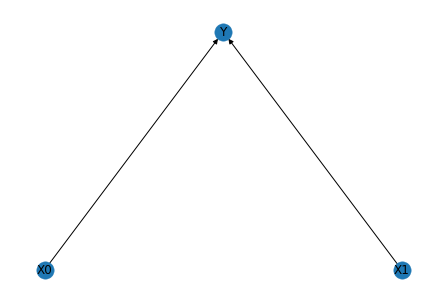

In [29]:
gg.vis_g(g)

## Using the graphical model `g` for causal estimates

First let's cast the graph into a form consumable by `dowhy.CausalModel`

In [51]:
#export
def get_gml(self, g:nx.DiGraph):
    return ''.join([v for v in nx.readwrite.gml.generate_gml(g)]); gml

GraphGenerator.get_gml = get_gml

In [52]:
gml = gg.get_gml(g); gml

'graph [  directed 1  node [    id 0    label "X0"  ]  node [    id 1    label "Y"  ]  node [    id 2    label "X1"  ]  edge [    source 0    target 1  ]  edge [    source 2    target 1  ]]'

Instantiating the `causal_model`

In [53]:
causal_model = dw.CausalModel(data=obs,  treatment=['X0'], 
                       outcome=target, graph=gml)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['X0'] on outcome ['Y']


Sanity checking that the model looks actually like what we had in mind with `g`, noticing that a node, U, was added between `treatment` and `outcome`, which is an unobserved confounder

INFO:dowhy.causal_graph:Using Matplotlib for plotting


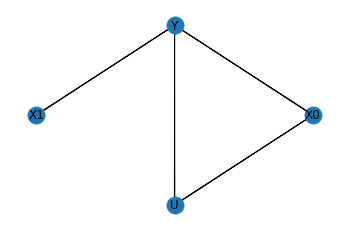

In [54]:
causal_model.view_model()

Generating the expression for the estimand

In [33]:
identified_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                  
─────(Expectation(Y))
d[X₀]                
Estimand assumption 1, Unconfoundedness: If U→{X0} and U→Y then P(Y|X0,,U) = P(Y|X0,)
### Estimand : 2
Estimand name: iv
No such variable found!



**Estimating the effect between treatment and control**. For this we need to define what the `treatment_value` and `control_value` are, respectively. This is what for each group the treatment, e.g. X0, will be set to. If it is binary then this can be translated into "received a drug" or "received a placebo" by, for example, using 0 and 1 respectively.

How `dowhy.CausalModel` handles the treatment input is specified with the second part in the `method_name` argument, the part after the dot. For example, when the treatement is of a categorical nature you can use `'propensity_score_stratification'`, or when it is of a continuous nature you can use `'linear_regression'`.

Still unclear:

* Difference between `'regression_discontinuity'` and `'linear_regression'`?

* Difference between `'instrumental_variable'` and `'backdoor'`?

In [61]:
# method_name = 'backdoor.propensity_score_stratification'
# method_name = 'backdoor.propensity_score_matching'
# method_name = 'backdoor.propensity_score_weighting'
method_name = 'backdoor.linear_regression'
# method_name = 'iv.instrumental_variable'
# method_name = 'iv.regression_discontinuity'

effect_kwargs = dict(
    method_name=method_name,
    control_value = 0,
    treatment_value = 1,
    target_units = 'ate',
    test_significance = True
)
causal_estimate = model.estimate_effect(identified_estimand,
                                        **effect_kwargs)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Y~X0+X0*X1


In [62]:
print(causal_estimate)

*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                  
─────(Expectation(Y))
d[X₀]                
Estimand assumption 1, Unconfoundedness: If U→{X0} and U→Y then P(Y|X0,,U) = P(Y|X0,)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~X0+X0*X1
## Estimate
Value: 1.4940299160360355

## Statistical Significance
p-value: <0.001



For the simple linear case using `method_name =  backdoor.linear_regression'` with `control_value = 0` and `treatment_value = 1` we get the slope of the (linear) relationship between treatment and outcome, which is ~1.5, just as the value used to generate the data

**Trying to refute the observed causal effect**. I see this as sanity checking the causal graph created to capture the observed data by trying to poke holes into it in various ways, like adding potentially spurious correlations with a new variable or replacing the treatment with noise.

`method_name`:
* "random_common_cause": Adding a randomly-generated confounder
* "add_unobserved_common_cause": Adding a confounder that is associated with both treatment and outcome
* "placebo_treatment_refuter": Replacing the treatment with a placebo (random) variable)
* "data_subset_refuter": Removing a random subset of the data

In [63]:
method_name = 'random_common_cause'
# method_name = 'add_unobserved_common_cause'
# method_name = 'placebo_treatment_refuter'
# method_name = 'data_subset_refuter'

refute_kwargs = dict(
    method_name=method_name,
    placebo_type = "permute",  # relevant for placebo refutation
    subset_fraction = .9,  # relevant for subset refutation
)

refute_res = model.refute_estimate(identified_estimand, 
                                   causal_estimate, 
                                   **refute_kwargs)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Y~X0+w_random+X0*X1


In [64]:
print(refute_res)

Refute: Add a Random Common Cause
Estimated effect:(1.4940299160360355,)
New effect:(1.4940297495480617,)

